## Calculating Carbon Stock

Check SOC related data and HARMONIZE to 30 cm

In [1]:
##load data from database

# === 1. Imports ===
import pandas as pd
from sqlalchemy import create_engine

# === 2. Connect to PostgreSQL ===
# Replace with your actual credentials
USER = "inesschwartz"
PASSWORD = "aa4862aa"
HOST = "localhost"
PORT = "5432"
DB = "soils_angola"

engine = create_engine(f"postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB}")

# === 3. Load data from each table ===
# You can filter early to avoid huge pulls
analyses = pd.read_sql("SELECT * FROM analyses", engine)
morpho = pd.read_sql("SELECT * FROM morpho", engine)
site_info = pd.read_sql("SELECT * FROM site_info", engine)
soil_type = pd.read_sql("SELECT * FROM soil_type", engine)
samples = pd.read_sql("SELECT * FROM samples", engine)
usable_sites = pd.read_sql("SELECT * FROM usable_site_info", engine)
climate_feat = pd.read_sql("SELECT * FROM climate_feat", engine)


In [16]:
morpho.head()

,morpho_id,sample_id,profile,horizon_layer,upper_depth,lower_depth,moisture_degree,root_quantity,root_diameter,texture,...,dry_chroma,moist_color_name,moist_hue,moist_value,moist_chroma,compaction,durability,friability,thick_contents_count,thick_contents_nature
0,B_101/62_1_1,10999,101_62,1.0,0.0,11.0,Seco,Muitas finas e bastantes medias,,Arenoso,...,2.5,Pardo-acinzentado-escuro,10YR,4.0,2.0,Pequena a minima,Brando,,,
1,B_101/62_2_1,11000,101_62,2.0,11.0,28.0,Seco,Bastantes finas e medias e raras grossas,,Arenoso-franco,...,3.0,Pardo-amarelado-escuro,10YR,3.0,4.0,Pequena,Brando,,,
2,B_101/62_3_1,11001,101_62,3.0,28.0,54.0,Seco,Algumas finas e medias e raras grossas,,Arenoso-franco,...,4.0,Pardo-amarelado-escuro,10YR,4.0,4.0,Pequena a minima,Brando,,,
3,B_101/62_4_1,11002,101_62,4.0,54.0,90.0,Seco,"Poucas finas, algumas medias e raras grossas",,Franco-arenoso a arenoso-franco,...,6.0,Pardo-forte,"7,5YR",5.0,6.0,Pequena a minima,Brando,,,
4,B_101/62_5_2,11003,101_62,5.0,90.0,160.0,Seco a humido,Raras,Medias e grossas,Arenoso-franco,...,6.0,Pardo-forte,"7,5YR",5.0,6.0,Pequena,Brando,,,


In [17]:
# === 3. CREATE MERGED DATASET ===

# Columns to select from analyses
analyses_cols = [
    'analysis_id', 'morpho_id', 'sample_id', 'profile', 'upper_depth', 'lower_depth',
    'thick_sand', 'fine_sand', 'silt', 'clay', 'atm_15', 'free_iron', 
    'organic_carbon', 'p205', 'organic_material', 'ph_h2o', 'ph_kcl', 
    'exchangable_bases_sum', 'cec', 'sample_depth', 'bulk_density', 'porosity'
]

# Subset analyses to relevant columns, ignoring missing cols gracefully
analyses_subset = analyses[[col for col in analyses_cols if col in analyses.columns]].copy()

# Filter analyses and morpho to only profiles present in site_info
valid_profiles = site_info['profile'].dropna().unique()

analyses_filtered = analyses_subset[analyses_subset['profile'].isin(valid_profiles)]
morpho_filtered = morpho[morpho['profile'].isin(valid_profiles)]

# Ensure matching dtypes for merge keys
analyses_filtered['sample_id'] = analyses_filtered['sample_id'].astype(str)
morpho_filtered['sample_id'] = morpho_filtered['sample_id'].astype(str)  # optional, since already object

# Now merge
combined_data = pd.merge(
    analyses_filtered,
    morpho_filtered,
    on=['profile', 'sample_id'],
    how='outer',
    suffixes=('', '_morpho')
)


# Inner join with site_info to keep only profiles with site info
merged_final = pd.merge(
    combined_data,
    site_info,
    on='profile',
    how='inner'
)

# Now merge with samples to add 'year' by sample_id
# Assuming 'samples' DataFrame is loaded and has 'sample_id' and 'year' columns
merged_final = pd.merge(
    merged_final,
    samples[['sample_id', 'year']],
    on='sample_id',
    how='inner'
)


**Dealing with Course fragments**

Coarse fragment contents were harmonized from qualitative field descriptions into quantitative percentage ranges using established abundance classes from international soil classification systems (FAO, 2006; IUSS Working Group WRB, 2022; USDA Soil Survey Manual, 2017). Terms such as raro, algum, bastante, muito, abundante, predomínio, and abundantíssimo were aligned with standard volumetric classes of rock fragments: e.g., algum/pouco (<10%), bastante (10–25%), muito (25–45%), abundante (45–55%), predomínio (55–80%), abundantíssimo (>80%), with rare or accidental occurrences assigned 0–2%. When descriptors included ranges (e.g., algum a bastante), the span of the two classes was used, while combinations with e (e.g., muito e algum) were treated as mixtures, with the overall minimum and maximum retained. For each description, a low, high, and midpoint (%) estimate was derived, ensuring both reproducibility and uncertainty tracking in soil organic carbon stock calculations.

References

FAO (2006). Guidelines for Soil Description (4th ed.). FAO, Rome.

IUSS Working Group WRB (2022). World Reference Base for Soil Resources, International soil classification system for naming soils and creating legends for soil maps. 4th edition. IUSS, Vienna.

Soil Survey Staff (2017). Soil Survey Manual. USDA Handbook 18, Washington, D.C.

In [20]:
# dealing with mapping thick_contents_count to a course fragment percentage

import pandas as pd
import numpy as np
import re

# Base mapping: Portuguese terms → (low, high, midpoint)
base_classes = {
    "rarissimo": (0, 2, 1),
    "acidental": (0, 2, 1),
    "raro": (0, 5, 2.5),
    "pouco": (0, 10, 5),
    "algum": (0, 10, 5),
    "bastante": (10, 25, 17.5),
    "muito": (25, 45, 35),
    "abundante": (45, 55, 50),
    "abundantes": (45, 55, 50),
    "abundantissimo": (80, 90, 85),
    "predominio": (55, 80, 67.5),
    "ligeiro predominio": (45, 55, 50),
    "partes sensivelmente iguais": (45, 55, 50),
}

def parse_frag_label(label):
    if pd.isna(label) or str(label).strip() == "" or label.strip() == "0":
        return (0, 0, 0)

    s = str(label).lower()
    # collect all known terms in string
    matches = [v for k, v in base_classes.items() if k in s]

    if not matches:
        return (np.nan, np.nan, np.nan)

    lows = [m[0] for m in matches]
    highs = [m[1] for m in matches]

    low, high = min(lows), max(highs)
    mid = (low + high) / 2
    return (low, high, mid)

# Example: apply to your dataframe
merged_final[["frag_low", "frag_high", "frag_mid"]] = (
    merged_final["thick_contents_count"]
    .apply(parse_frag_label)
    .apply(pd.Series)
)


**Calculating Carbon Stock**

1) Dataframe selection
2) Units of organic carbon g/kg and then divide by 10 to get %
3) Correct bulk density for coarse fragments
4) Calculate SOC stock per horizon (FAO equation):

In [22]:
ca

In [23]:
# Uncertainty bounds using frag_low & frag_high:
SOC_dataset["bd_low"] = SOC_dataset["bulk_density"] * (1 - SOC_dataset["frag_high"]/100)
SOC_dataset["bd_high"] = SOC_dataset["bulk_density"] * (1 - SOC_dataset["frag_low"]/100)

SOC_dataset["soc_stock_low"] = SOC_dataset["bd_low"] * SOC_dataset["thickness_m"] * SOC_dataset["soc_percent"] * 10
SOC_dataset["soc_stock_high"] = SOC_dataset["bd_high"] * SOC_dataset["thickness_m"] * SOC_dataset["soc_percent"] * 10

In [29]:
SOC_dataset.head

<bound method NDFrame.head of      site_info_id     analysis_id profile  upper_depth  lower_depth  \
0            2139   Hb_100/56_1_1  100_56          0.0          7.0   
1            2139   Hb_100/56_2_1  100_56          7.0         20.0   
2            2139   Hb_100/56_3_1  100_56         20.0         67.0   
3            2139  Hb_100/56_4_21  100_56         67.0        190.0   
4            2139  Hb_100/56_4_22  100_56          NaN          NaN   
...           ...             ...     ...          ...          ...   
6715          960     Mj_9/63_1_1    9_63          0.0          6.0   
6716          960     Mj_9/63_2_1    9_63          6.0         14.0   
6717          960     Mj_9/63_3_1    9_63         14.0         31.0   
6718          960     Mj_9/63_4_1    9_63         31.0         58.0   
6719          960     Mj_9/63_5_1    9_63         58.0         90.0   

      organic_carbon    X_coord    Y_coord  bulk_density  frag_mid  frag_low  \
0               1.29  16.269295 -12.5

**harmonize to target depth 0-30cm**


FAO recommends using mass-preserving splines (e.g. isric-org/mpspline in R or pyspline in Python) to standardize SOC stock to 0–30 cm. 

The workflow is:

Calculate per-horizon SOC stock (above).

Fit spline to profile horizons (SOC% and BD, not just stock).

Integrate spline to get SOC stock in the exact 0–30 cm depth interval

In [38]:
import pandas as pd
import numpy as np
from scipy.interpolate import UnivariateSpline
import warnings

# ------------------------------
# Suppress minor spline warnings
# ------------------------------
warnings.filterwarnings("ignore", category=UserWarning)

# ------------------------------
# 1) Specify dataset
# ------------------------------
SOC_dataset = merged_final[['site_info_id', 'analysis_id', 'profile',
                            'upper_depth', 'lower_depth', 'organic_carbon',
                            'X_coord', 'Y_coord', 'bulk_density',
                            'frag_mid', 'frag_low', 'frag_high']].copy()

# Harmonize organic carbon units (percent)
if SOC_dataset["organic_carbon"].max() > 50:
    SOC_dataset["soc_percent"] = SOC_dataset["organic_carbon"] / 10
else:
    SOC_dataset["soc_percent"] = SOC_dataset["organic_carbon"]

# ------------------------------
# 2) Mass-preserving spline function
# ------------------------------
def fit_mpspline(depth_top, depth_bottom, values, lam=1.0, target_depths=[0,30]):
    depth_top = np.array(depth_top)
    depth_bottom = np.array(depth_bottom)
    values = np.array(values)
    
    # Remove NaNs
    mask = ~np.isnan(depth_top) & ~np.isnan(depth_bottom) & ~np.isnan(values)
    depth_top = depth_top[mask]
    depth_bottom = depth_bottom[mask]
    values = values[mask]
    
    n = len(values)
    if n == 0:
        return np.nan
    elif n == 1:
        return values[0]
    elif n == 2:
        thickness = depth_bottom - depth_top
        return np.average(values, weights=thickness)
    
    # Compute midpoints and sort
    midpoints = (depth_top + depth_bottom) / 2
    sort_idx = np.argsort(midpoints)
    midpoints = midpoints[sort_idx]
    values = values[sort_idx]
    
    # Remove duplicate midpoints
    unique_midpoints, unique_indices = np.unique(midpoints, return_index=True)
    values = values[unique_indices]
    
    k = min(3, len(values)-1)  # spline degree <= n-1
    spline = UnivariateSpline(unique_midpoints, values, s=lam, k=k)
    
    top, bottom = target_depths
    integral = spline.integral(top, bottom)
    return integral / (bottom - top)

# ------------------------------
# 3) Harmonize profiles
# ------------------------------
profiles = SOC_dataset['profile'].unique()
harmonized_list = []

for pid in profiles:
    profile = SOC_dataset[SOC_dataset['profile'] == pid]
    
    # Skip profiles with no valid SOC or BD
    if profile['soc_percent'].isna().all() or profile['bulk_density'].isna().all():
        continue
    
    # Harmonize SOC%, bulk density, and coarse fragments (0–30 cm)
    soc_h = fit_mpspline(profile['upper_depth'], profile['lower_depth'], profile['soc_percent'], lam=1.0, target_depths=[0,30])
    bd_h  = fit_mpspline(profile['upper_depth'], profile['lower_depth'], profile['bulk_density'], lam=1.0, target_depths=[0,30])
    cf_h  = fit_mpspline(profile['upper_depth'], profile['lower_depth'], profile['frag_mid'], lam=1.0, target_depths=[0,30])
    
    # Correct bulk density for coarse fragments
    bd_corrected = bd_h * (1 - cf_h / 100)
    
    # SOC stock (Mg C ha-1) for 0–30 cm
    soc_stock = bd_corrected * 0.30 * soc_h * 10  # depth in m, factor 10 converts units
    
    harmonized_list.append({
        'profile': pid,
        'soc_harmonized_percent': soc_h,
        'bd_harmonized': bd_h,
        'cf_harmonized_percent': cf_h,
        'bd_corrected': bd_corrected,
        'soc_stock_0_30cm': soc_stock
    })

# ------------------------------
# 4) Create final dataframe
# ------------------------------
harmonized_df = pd.DataFrame(harmonized_list)

# Remove any fully empty rows (if present)
harmonized_df.dropna(subset=['soc_harmonized_percent', 'bd_harmonized'], inplace=True)

# Preview
print(harmonized_df.head())

# Optional: save to CSV
# harmonized_df.to_csv("harmonized_soc_0_30cm.csv", index=False)


   profile  soc_harmonized_percent  bd_harmonized  cf_harmonized_percent  \
0   100_56                0.723829       1.364573              22.330033   
1   100_58                1.229639       1.069746               2.318051   
2   100_59                0.755000       1.294747               2.500000   
4   100_63                0.353306       1.434771               0.053287   
6  101A_58                0.767291       1.149793               2.166667   

   bd_corrected  soc_stock_0_30cm  
0      1.059864          2.301481  
1      1.044949          3.854732  
2      1.262378          2.859287  
4      1.434006          1.519928  
6      1.124881          2.589333  


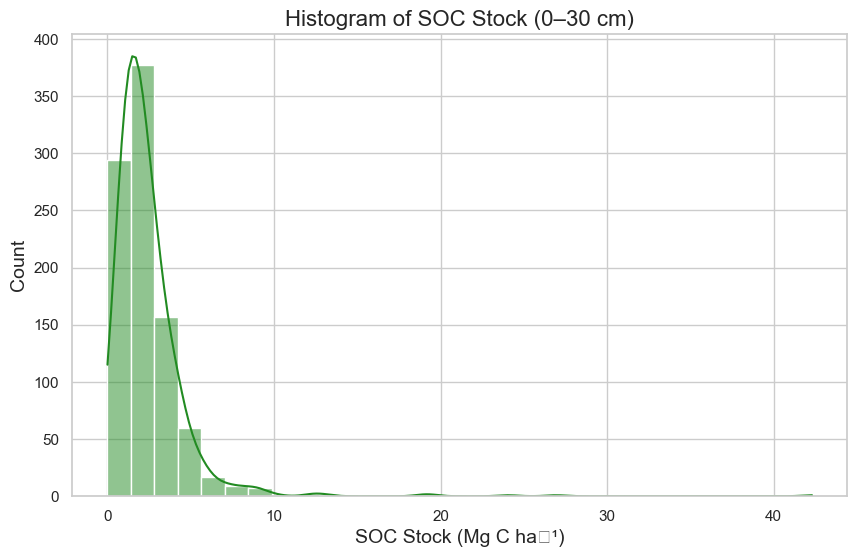

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: use Seaborn style
sns.set(style="whitegrid")

# Plot histogram
plt.figure(figsize=(10,6))
sns.histplot(harmonized_df['soc_stock_0_30cm_t_ha'], bins=30, kde=True, color='forestgreen')
plt.title('Histogram of SOC Stock (0–30 cm)', fontsize=16)
plt.xlabel('SOC Stock (Mg C ha⁻¹)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

In [43]:
harmonized_df = harmonized_df.rename(columns={'soc_stock_0_30cm': 'soc_stock_0_30cm_t_ha'})


In [44]:
# Summary statistics
harmonized_df['soc_stock_0_30cm_t_ha'].describe()


count    930.000000
mean       2.442184
std        2.497126
min       -0.992454
25%        1.230618
50%        1.934346
75%        2.974344
max       42.303773
Name: soc_stock_0_30cm_t_ha, dtype: float64

In [45]:
harmonized_df['soc_stock_0_30cm_t_ha'] = harmonized_df['soc_stock_0_30cm_t_ha'].clip(lower=0)
